## HIPOTESIS 2: Las energías renovables  incrementan el beneficio de las energéticas​

1. Importa pyplot, numpy y pandas

In [10]:
pip install scipy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
pip install statsmodels


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from io import StringIO
import seaborn as sns
import matplotlib.dates as mdates
from scipy.stats import pearsonr
import statsmodels.api as sm

In [2]:
# 1. Cargar datasets
df1 = pd.read_csv("../Data/energy_dataset.csv", parse_dates=["time"], na_values=["", " "])
df2 = pd.read_csv("../Data/spain_energy_market.csv", parse_dates=["datetime"])

# 2. Convertir a datetime si no lo están, y eliminar zona horaria
df1["time"] = pd.to_datetime(df1["time"], errors="coerce", utc=True).dt.tz_convert(None)
df2["datetime"] = pd.to_datetime(df2["datetime"], errors="coerce").dt.tz_localize(None)

# 3. Crear columna de fecha
df1["date"] = df1["time"].dt.normalize()
df2["date"] = df2["datetime"].dt.normalize()

# 4. Agrupar precio spot diario
df2_daily = df2[["date", "value"]].rename(columns={"value": "spot_price_daily"})

# 5. Unir por fecha
df = df1.merge(df2_daily, on="date", how="left").drop(columns=["date"])

# 6. Exportar si quieres
df.to_csv("../Data/energy_merged.csv", index=False)

In [3]:
print(df1["time"].dtype)
print(df1["time"].head())

datetime64[ns]
0   2014-12-31 23:00:00
1   2015-01-01 00:00:00
2   2015-01-01 01:00:00
3   2015-01-01 02:00:00
4   2015-01-01 03:00:00
Name: time, dtype: datetime64[ns]


In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777248 entries, 0 to 777247
Data columns (total 30 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   time                                         777248 non-null  datetime64[ns]
 1   generation biomass                           776838 non-null  float64       
 2   generation fossil brown coal/lignite         776861 non-null  float64       
 3   generation fossil coal-derived gas           776861 non-null  float64       
 4   generation fossil gas                        776861 non-null  float64       
 5   generation fossil hard coal                  776861 non-null  float64       
 6   generation fossil oil                        776840 non-null  float64       
 7   generation fossil oil shale                  776861 non-null  float64       
 8   generation fossil peat                       776861 non-null  fl

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,spot_price_daily
count,777248,776838.000000,776861.000000,776861.0,776861.000000,776861.000000,776840.000000,776861.0,776861.0,776861.0,...,776861.0,776861.000000,777248.000000,0.0,777248.000000,777248.000000,776448.000000,777248.000000,777248.000000,7.772480e+05
mean,2016-12-31 14:21:49.648400896,383.384045,447.780895,0.0,5622.831451,4255.807467,298.277765,0.0,0.0,0.0,...,0.0,5475.720013,1434.323859,NaN,5482.418211,28711.321953,28696.070609,49.870730,57.899648,1.337948e+05
min,2014-12-31 23:00:00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000,-1.426133e+06
25%,2016-01-01 10:00:00,333.000000,0.000000,0.0,4124.000000,2526.000000,263.000000,0.0,0.0,0.0,...,0.0,2941.000000,68.000000,NaN,2986.000000,24790.000000,24805.000000,41.450000,49.340000,5.218208e+01
50%,2016-12-30 22:00:00,367.000000,509.000000,0.0,4966.000000,4475.000000,300.000000,0.0,0.0,0.0,...,0.0,4862.000000,574.000000,NaN,4869.000000,28907.000000,28904.000000,50.510000,58.030000,2.784444e+04
75%,2017-12-31 18:00:00,433.000000,757.000000,0.0,6426.000000,5841.000000,330.000000,0.0,0.0,0.0,...,0.0,7415.000000,2623.000000,NaN,7368.000000,32264.000000,32192.000000,60.530000,68.050000,1.610192e+05
max,2018-12-31 22:00:00,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,...,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000,2.584390e+06
std,NaN,85.386850,354.733949,0.0,2208.037221,1962.097121,52.516401,0.0,0.0,0.0,...,0.0,3217.586106,1675.190345,NaN,3180.283280,4596.117489,4576.581510,14.646941,14.231166,2.173195e+05


In [7]:
df_grouped = df.copy()

# Rellenar valores nulos con 0 para el cálculo de sumas de grupos.
df_filled_for_sum = df_grouped.fillna(0)

# Función auxiliar para sumar columnas presentes
def sumar_columnas_existentes(df, columnas, nombre_nueva_columna):
    columnas_presentes = [col for col in columnas if col in df.columns]
    if len(columnas_presentes) < len(columnas):
        columnas_faltantes = [col for col in columnas if col not in df.columns]
        print(f"Advertencia: Las siguientes columnas NO se encontraron: {columnas_faltantes}. Se usarán solo las existentes.")
    return df[columnas_presentes].sum(axis=1) if columnas_presentes else 0.0

# 1. Generación Fósil (sin 'generation fossil gas')
fosil = [
    'generation fossil brown coal/lignite',
    'generation fossil coal-derived gas',
    'generation fossil hard coal',
    'generation fossil oil',
    'generation fossil oil shale',
    'generation fossil peat'
]
df_grouped['total_generation_fosil'] = sumar_columnas_existentes(df_filled_for_sum, fosil, 'total_generation_fosil')

# 2. Generación Gas (solo 'generation fossil gas')
if 'generation fossil gas' in df_filled_for_sum.columns:
    df_grouped['total_generation_gas'] = df_filled_for_sum['generation fossil gas']
else:
    print("Advertencia: La columna 'generation fossil gas' no se encontró.")
    df_grouped['total_generation_gas'] = 0.0

# 3. Generación Solar
solar = ['generation solar']
df_grouped['total_generation_solar'] = sumar_columnas_existentes(df_filled_for_sum, solar, 'total_generation_solar')

# 4. Generación Eólica
eolica = ['generation wind offshore', 'generation wind onshore']
df_grouped['total_generation_eolica'] = sumar_columnas_existentes(df_filled_for_sum, eolica, 'total_generation_eolica')

# 5. Otras Renovables
otras_renovables = ['generation geothermal', 'generation other renewable', 'generation waste', 'generation marine']
df_grouped['total_generation_otras_renovables'] = sumar_columnas_existentes(df_filled_for_sum, otras_renovables, 'total_generation_otras_renovables')

# 6. Generación Hidráulica
hidraulica = [
    'generation hydro pumped storage aggregated',
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage',
    'generation hydro water reservoir'
]
df_grouped['total_generation_hidraulica'] = sumar_columnas_existentes(df_filled_for_sum, hidraulica, 'total_generation_hidraulica')

# 7. Generación Nuclear
if 'generation nuclear' in df_filled_for_sum.columns:
    df_grouped['total_generation_nuclear'] = df_filled_for_sum['generation nuclear']
else:
    print("Advertencia: La columna 'generation nuclear' no se encontró.")
    df_grouped['total_generation_nuclear'] = 0.0

# 8. Generación de Biomasa
if 'generation biomass' in df_filled_for_sum.columns:
    df_grouped['biomasa'] = df_filled_for_sum['generation biomass']
else:
    print("Advertencia: La columna 'generation biomass' no se encontró.")
    df_grouped['biomasa'] = 0.0

# 9. Otras Generaciones
if 'generation other' in df_filled_for_sum.columns:
    df_grouped['otras_generaciones'] = df_filled_for_sum['generation other']
else:
    print("Advertencia: La columna 'generation other' no se encontró.")
    df_grouped['otras_generaciones'] = 0.0

# Mostrar resultado resumido
print("\nDataFrame con las nuevas columnas de generación agrupadas (primeras 5 filas):")
print(df_grouped[['time',
                  'total_generation_fosil',
                  'total_generation_gas',
                  'total_generation_solar',
                  'total_generation_eolica',
                  'total_generation_otras_renovables',
                  'total_generation_hidraulica',
                  'total_generation_nuclear',
                  'biomasa',
                  'otras_generaciones']].head())

# Verificar info
print("\nInformación del DataFrame después de la agrupación:")
df_grouped.info()


DataFrame con las nuevas columnas de generación agrupadas (primeras 5 filas):
                 time  total_generation_fosil  total_generation_gas  \
0 2014-12-31 23:00:00                  5312.0                4844.0   
1 2014-12-31 23:00:00                  5312.0                4844.0   
2 2014-12-31 23:00:00                  5312.0                4844.0   
3 2014-12-31 23:00:00                  5312.0                4844.0   
4 2014-12-31 23:00:00                  5312.0                4844.0   

   total_generation_solar  total_generation_eolica  \
0                    49.0                   6378.0   
1                    49.0                   6378.0   
2                    49.0                   6378.0   
3                    49.0                   6378.0   
4                    49.0                   6378.0   

   total_generation_otras_renovables  total_generation_hidraulica  \
0                              269.0                       3813.0   
1                              

In [8]:
df_grouped = df.copy()
df_filled_for_sum = df_grouped.fillna(0)

# Función auxiliar
def sumar_columnas_existentes(df, columnas, nombre_nueva_columna):
    columnas_presentes = [col for col in columnas if col in df.columns]
    if len(columnas_presentes) < len(columnas):
        columnas_faltantes = [col for col in columnas if col not in df.columns]
        print(f"Advertencia: Las siguientes columnas NO se encontraron: {columnas_faltantes}. Se usarán solo las existentes.")
    return df[columnas_presentes].sum(axis=1) if columnas_presentes else 0.0

# Renovables
renovables = [
    'generation solar',
    'generation wind onshore',
    'generation wind offshore',
    'generation hydro pumped storage aggregated',
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage',
    'generation hydro water reservoir',
    'generation geothermal',
    'generation other renewable',
    'generation waste',
    'generation marine',
    'generation biomass'
]
df_grouped['total_generation_renovables'] = sumar_columnas_existentes(df_filled_for_sum, renovables, 'total_generation_renovables')

# No Renovables
no_renovables = [
    'generation fossil brown coal/lignite',
    'generation fossil coal-derived gas',
    'generation fossil gas',
    'generation fossil hard coal',
    'generation fossil oil',
    'generation fossil oil shale',
    'generation fossil peat',
    'generation nuclear',
    'generation other'  # si aplica como no renovable
]
df_grouped['total_generation_no_renovables'] = sumar_columnas_existentes(df_filled_for_sum, no_renovables, 'total_generation_no_renovables')

# Vista previa
print("\nResumen de generación agrupada (primeras 5 filas):")
print(df_grouped[['time', 'total_generation_renovables', 'total_generation_no_renovables']].head())

# Verificación
print("\nInformación del DataFrame después de la agrupación:")
df_grouped.info()


Resumen de generación agrupada (primeras 5 filas):
                 time  total_generation_renovables  \
0 2014-12-31 23:00:00                      10956.0   
1 2014-12-31 23:00:00                      10956.0   
2 2014-12-31 23:00:00                      10956.0   
3 2014-12-31 23:00:00                      10956.0   
4 2014-12-31 23:00:00                      10956.0   

   total_generation_no_renovables  
0                         17295.0  
1                         17295.0  
2                         17295.0  
3                         17295.0  
4                         17295.0  

Información del DataFrame después de la agrupación:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777248 entries, 0 to 777247
Data columns (total 32 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   time                                         777248 non-null  datetime64[n

In [9]:
df_grouped = df.copy()
df_filled_for_sum = df_grouped.fillna(0)

# Función auxiliar
def sumar_columnas_existentes(df, columnas, nombre_nueva_columna):
    columnas_presentes = [col for col in columnas if col in df.columns]
    if len(columnas_presentes) < len(columnas):
        columnas_faltantes = [col for col in columnas if col not in df.columns]
        print(f"Advertencia: Las siguientes columnas NO se encontraron: {columnas_faltantes}. Se usarán solo las existentes.")
    return df[columnas_presentes].sum(axis=1) if columnas_presentes else 0.0

# Grupos
fosil = [
    'generation fossil brown coal/lignite',
    'generation fossil coal-derived gas',
    'generation fossil hard coal',
    'generation fossil oil',
    'generation fossil oil shale',
    'generation fossil peat'
]
gas = ['generation fossil gas']
solar = ['generation solar']
eolica = ['generation wind onshore', 'generation wind offshore']
otras_renovables = ['generation geothermal', 'generation other renewable', 'generation waste', 'generation marine']
hidraulica = [
    'generation hydro pumped storage aggregated',
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage',
    'generation hydro water reservoir'
]
biomasa = ['generation biomass']
nuclear = ['generation nuclear']
otras = ['generation other']

# Renovables = solar + eólica + hidráulica + otras renovables + biomasa
renovables = solar + eolica + hidraulica + otras_renovables + biomasa
no_renovables = fosil + gas + nuclear + otras

# Totales por grupo
df_grouped['total_generation_fosil'] = sumar_columnas_existentes(df_filled_for_sum, fosil, 'total_generation_fosil')
df_grouped['total_generation_gas'] = sumar_columnas_existentes(df_filled_for_sum, gas, 'total_generation_gas')
df_grouped['total_generation_solar'] = sumar_columnas_existentes(df_filled_for_sum, solar, 'total_generation_solar')
df_grouped['total_generation_eolica'] = sumar_columnas_existentes(df_filled_for_sum, eolica, 'total_generation_eolica')
df_grouped['total_generation_otras_renovables'] = sumar_columnas_existentes(df_filled_for_sum, otras_renovables, 'total_generation_otras_renovables')
df_grouped['total_generation_hidraulica'] = sumar_columnas_existentes(df_filled_for_sum, hidraulica, 'total_generation_hidraulica')
df_grouped['total_generation_nuclear'] = sumar_columnas_existentes(df_filled_for_sum, nuclear, 'total_generation_nuclear')
df_grouped['biomasa'] = sumar_columnas_existentes(df_filled_for_sum, biomasa, 'biomasa')
df_grouped['otras_generaciones'] = sumar_columnas_existentes(df_filled_for_sum, otras, 'otras_generaciones')

# Agregados principales
df_grouped['total_generation_renovables'] = sumar_columnas_existentes(df_filled_for_sum, renovables, 'total_generation_renovables')
df_grouped['total_generation_no_renovables'] = sumar_columnas_existentes(df_filled_for_sum, no_renovables, 'total_generation_no_renovables')

# Total de generación por fila
df_grouped['total_generation'] = df_grouped[
    ['total_generation_renovables', 'total_generation_no_renovables']
].sum(axis=1)

# Porcentajes
def porcentaje(col):
    return (df_grouped[col] / df_grouped['total_generation']) * 100

df_grouped['%_renovables'] = porcentaje('total_generation_renovables')
df_grouped['%_no_renovables'] = porcentaje('total_generation_no_renovables')
df_grouped['%_fosil'] = porcentaje('total_generation_fosil')
df_grouped['%_gas'] = porcentaje('total_generation_gas')
df_grouped['%_solar'] = porcentaje('total_generation_solar')
df_grouped['%_eolica'] = porcentaje('total_generation_eolica')
df_grouped['%_hidraulica'] = porcentaje('total_generation_hidraulica')
df_grouped['%_nuclear'] = porcentaje('total_generation_nuclear')
df_grouped['%_biomasa'] = porcentaje('biomasa')
df_grouped['%_otras_generaciones'] = porcentaje('otras_generaciones')

# Mostrar una vista previa
columnas_mostrar = [
    'time',
    'total_generation', 'total_generation_renovables', 'total_generation_no_renovables',
    '%_renovables', '%_no_renovables', '%_fosil', '%_gas',
    '%_solar', '%_eolica', '%_hidraulica', '%_nuclear', '%_biomasa', '%_otras_generaciones'
]

print("\nResumen con porcentajes (primeras 5 filas):")
print(df_grouped[columnas_mostrar].head())


Resumen con porcentajes (primeras 5 filas):
                 time  total_generation  total_generation_renovables  \
0 2014-12-31 23:00:00           28251.0                      10956.0   
1 2014-12-31 23:00:00           28251.0                      10956.0   
2 2014-12-31 23:00:00           28251.0                      10956.0   
3 2014-12-31 23:00:00           28251.0                      10956.0   
4 2014-12-31 23:00:00           28251.0                      10956.0   

   total_generation_no_renovables  %_renovables  %_no_renovables    %_fosil  \
0                         17295.0     38.780928        61.219072  18.802874   
1                         17295.0     38.780928        61.219072  18.802874   
2                         17295.0     38.780928        61.219072  18.802874   
3                         17295.0     38.780928        61.219072  18.802874   
4                         17295.0     38.780928        61.219072  18.802874   

       %_gas   %_solar   %_eolica  %_hidraulica

In [14]:
print(df_grouped.columns)

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'spot_price_daily', 'total_generation_fosil',
       'total_generation_gas', 'total_gener

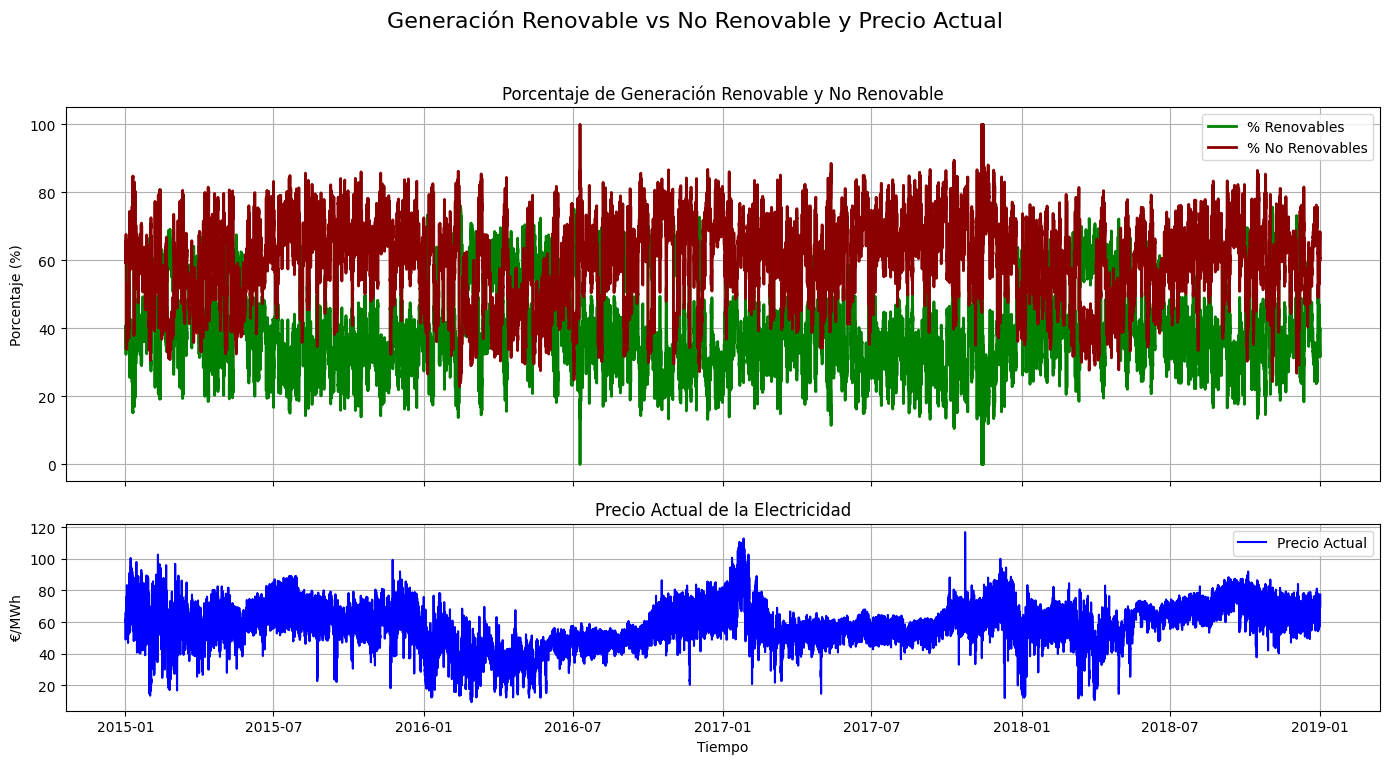

In [16]:
# Asegúrate de que la columna 'time' esté en formato datetime
df_grouped['time'] = pd.to_datetime(df_grouped['time'])

# Crear figura y subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle("Generación Renovable vs No Renovable y Precio Actual", fontsize=16)

# --- Gráfico superior: Porcentaje Renovables vs No Renovables ---
ax1.plot(df_grouped['time'], df_grouped['%_renovables'], label='% Renovables', color='green', linewidth=2)
ax1.plot(df_grouped['time'], df_grouped['%_no_renovables'], label='% No Renovables', color='darkred', linewidth=2)
ax1.set_ylabel('Porcentaje (%)')
ax1.set_title('Porcentaje de Generación Renovable y No Renovable')
ax1.legend(loc='upper right')
ax1.grid(True)

# --- Gráfico inferior: Precio Actual ---
ax2.plot(df_grouped['time'], df_grouped['price actual'], label='Precio Actual', color='blue', linewidth=1.5)
ax2.set_ylabel('€/MWh')
ax2.set_xlabel('Tiempo')
ax2.set_title('Precio Actual de la Electricidad')
ax2.legend(loc='upper right')
ax2.grid(True)

# Ajuste de diseño
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

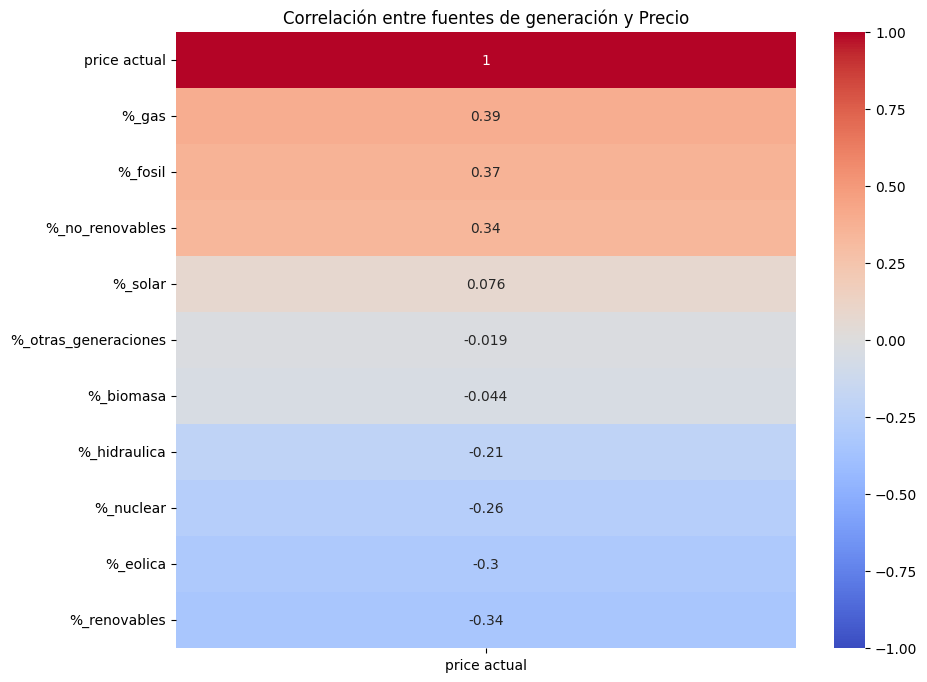

In [22]:
# Seleccionar columnas relevantes
columnas_analisis = [
    '%_fosil', '%_gas', '%_solar', '%_eolica',
    '%_hidraulica', '%_nuclear', '%_biomasa',
    '%_otras_generaciones', '%_renovables',
    '%_no_renovables', 'price actual'
]

# Calcular correlación
correlation_matrix = df_grouped[columnas_analisis].corr()

# Visualizar con heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['price actual']].sort_values(by='price actual', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlación entre fuentes de generación y Precio")
plt.show()

In [24]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Seleccionar las columnas que necesitas
columnas_modelo = [
    '%_fosil', '%_gas', '%_solar', '%_eolica',
    '%_hidraulica', '%_nuclear', '%_biomasa',
    '%_otras_generaciones', 'price actual'
]

# Eliminar filas con valores NaN en las columnas del modelo
df_modelo = df_grouped[columnas_modelo].dropna()

# Separar variables predictoras (X) y variable objetivo (y)
X = df_modelo.drop(columns=['price actual'])
y = df_modelo['price actual']

# Crear y entrenar el modelo
modelo = LinearRegression()
modelo.fit(X, y)

# Mostrar coeficientes
print("Coeficientes de la regresión lineal:")
for var, coef in zip(X.columns, modelo.coef_):
    print(f"{var}: {coef:.4f}")

# Evaluar el modelo
r2 = r2_score(y, modelo.predict(X))
print(f"\nR² del modelo: {r2:.4f}")

Coeficientes de la regresión lineal:
%_fosil: 1.8605
%_gas: 1.8811
%_solar: 1.5171
%_eolica: 1.3366
%_hidraulica: 1.3017
%_nuclear: 0.7688
%_biomasa: -3.2517
%_otras_generaciones: 12.6627

R² del modelo: 0.2554


In [78]:
df_grouped = df.copy()

# Rellenar valores nulos con 0 para el cálculo de sumas de grupos.
df_filled_for_sum = df_grouped.fillna(0)

# Función auxiliar para sumar columnas presentes
def sumar_columnas_existentes(df, columnas, nombre_nueva_columna):
    columnas_presentes = [col for col in columnas if col in df.columns]
    if len(columnas_presentes) < len(columnas):
        columnas_faltantes = [col for col in columnas if col not in df.columns]
        print(f"Advertencia: Las siguientes columnas NO se encontraron: {columnas_faltantes}. Se usarán solo las existentes.")
    return df[columnas_presentes].sum(axis=1) if columnas_presentes else 0.0

# 1. Generación Fósil
fosil = [
    'generation fossil brown coal/lignite',
    'generation fossil coal-derived gas',
    'generation fossil gas',
    'generation fossil hard coal',
    'generation fossil oil',
    'generation fossil oil shale',
    'generation fossil peat'
]
df_grouped['total_generation_fosil'] = sumar_columnas_existentes(df_filled_for_sum, fosil, 'total_generation_fosil')

# 2. Generación Solar
solar = ['generation solar']
df_grouped['total_generation_solar'] = sumar_columnas_existentes(df_filled_for_sum, solar, 'total_generation_solar')

# 3. Generación Eólica
eolica = ['generation wind offshore', 'generation wind onshore']
df_grouped['total_generation_eolica'] = sumar_columnas_existentes(df_filled_for_sum, eolica, 'total_generation_eolica')

# 4. Otras Renovables
otras_renovables = ['generation geothermal', 'generation other renewable', 'generation waste', 'generation marine']
df_grouped['total_generation_otras_renovables'] = sumar_columnas_existentes(df_filled_for_sum, otras_renovables, 'total_generation_otras_renovables')

# 5. Generación Hidráulica
hidraulica = [
    'generation hydro pumped storage aggregated',
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage',
    'generation hydro water reservoir'
]
df_grouped['total_generation_hidraulica'] = sumar_columnas_existentes(df_filled_for_sum, hidraulica, 'total_generation_hidraulica')

# 6. Generación Nuclear
if 'generation nuclear' in df_filled_for_sum.columns:
    df_grouped['total_generation_nuclear'] = df_filled_for_sum['generation nuclear']
else:
    print("Advertencia: La columna 'generation nuclear' no se encontró.")
    df_grouped['total_generation_nuclear'] = 0.0

# 7. Generación de Biomasa
if 'generation biomass' in df_filled_for_sum.columns:
    df_grouped['biomasa'] = df_filled_for_sum['generation biomass']
else:
    print("Advertencia: La columna 'generation biomass' no se encontró.")
    df_grouped['biomasa'] = 0.0

# 8. Otras Generaciones
if 'generation other' in df_filled_for_sum.columns:
    df_grouped['otras_generaciones'] = df_filled_for_sum['generation other']
else:
    print("Advertencia: La columna 'generation other' no se encontró.")
    df_grouped['otras_generaciones'] = 0.0

# Mostrar resultado resumido
print("\nDataFrame con las nuevas columnas de generación agrupadas (primeras 5 filas):")
print(df_grouped[['time',
                  'total_generation_fosil',
                  'total_generation_solar',
                  'total_generation_eolica',
                  'total_generation_otras_renovables',
                  'total_generation_hidraulica',
                  'total_generation_nuclear',
                  'biomasa',
                  'otras_generaciones']].head())

# Verificar info
print("\nInformación del DataFrame después de la agrupación:")
df_grouped.info()


DataFrame con las nuevas columnas de generación agrupadas (primeras 5 filas):
                 time  total_generation_fosil  total_generation_solar  \
0 2014-12-31 23:00:00                 10156.0                    49.0   
1 2014-12-31 23:00:00                 10156.0                    49.0   
2 2014-12-31 23:00:00                 10156.0                    49.0   
3 2014-12-31 23:00:00                 10156.0                    49.0   
4 2014-12-31 23:00:00                 10156.0                    49.0   

   total_generation_eolica  total_generation_otras_renovables  \
0                   6378.0                              269.0   
1                   6378.0                              269.0   
2                   6378.0                              269.0   
3                   6378.0                              269.0   
4                   6378.0                              269.0   

   total_generation_hidraulica  total_generation_nuclear  biomasa  \
0                     

In [81]:
# Agrupar en renovables y no renovables
df_grouped['total_generation_renovable'] = (
    df_grouped['total_generation_solar'] +
    df_grouped['total_generation_eolica'] +
    df_grouped['total_generation_hidraulica'] +
    df_grouped['biomasa'] +
    df_grouped['total_generation_otras_renovables']
)

df_grouped['total_generation_no_renovable'] = (
    df_grouped['total_generation_fosil'] +
    df_grouped['total_generation_nuclear'] +
    df_grouped['otras_generaciones']
)

# Mostrar las nuevas columnas creadas
print("\nPrimeras 5 filas con las columnas renovables y no renovables:")
print(df_grouped[['time', 'total_generation_renovable', 'total_generation_no_renovable']].head())


Primeras 5 filas con las columnas renovables y no renovables:
                 time  total_generation_renovable  \
0 2014-12-31 23:00:00                     10956.0   
1 2014-12-31 23:00:00                     10956.0   
2 2014-12-31 23:00:00                     10956.0   
3 2014-12-31 23:00:00                     10956.0   
4 2014-12-31 23:00:00                     10956.0   

   total_generation_no_renovable  
0                        17295.0  
1                        17295.0  
2                        17295.0  
3                        17295.0  
4                        17295.0  


In [82]:
# Calcular el total generado (suma de renovable y no renovable)
df_grouped['total_generation'] = (
    df_grouped['total_generation_renovable'] +
    df_grouped['total_generation_no_renovable']
)

# Evitar división por cero
df_grouped['porcentaje_renovable'] = (
    df_grouped['total_generation_renovable'] / df_grouped['total_generation']
).fillna(0) * 100

df_grouped['porcentaje_no_renovable'] = (
    df_grouped['total_generation_no_renovable'] / df_grouped['total_generation']
).fillna(0) * 100

# Mostrar resultado
print("\nPrimeras 5 filas con los porcentajes de renovable y no renovable:")
print(df_grouped[['time', 'porcentaje_renovable', 'porcentaje_no_renovable']].head())


Primeras 5 filas con los porcentajes de renovable y no renovable:
                 time  porcentaje_renovable  porcentaje_no_renovable
0 2014-12-31 23:00:00             38.780928                61.219072
1 2014-12-31 23:00:00             38.780928                61.219072
2 2014-12-31 23:00:00             38.780928                61.219072
3 2014-12-31 23:00:00             38.780928                61.219072
4 2014-12-31 23:00:00             38.780928                61.219072


In [83]:
# Asegurar que existe la columna de total generado
if 'total_generation' not in df_grouped.columns:
    df_grouped['total_generation'] = (
        df_grouped['total_generation_renovable'] +
        df_grouped['total_generation_no_renovable']
    )

# Evitar división por cero y calcular porcentajes
df_grouped['porcentaje_fosil'] = (df_grouped['total_generation_fosil'] / df_grouped['total_generation']).fillna(0) * 100
df_grouped['porcentaje_solar'] = (df_grouped['total_generation_solar'] / df_grouped['total_generation']).fillna(0) * 100
df_grouped['porcentaje_eolica'] = (df_grouped['total_generation_eolica'] / df_grouped['total_generation']).fillna(0) * 100
df_grouped['porcentaje_otras_renovables'] = (df_grouped['total_generation_otras_renovables'] / df_grouped['total_generation']).fillna(0) * 100
df_grouped['porcentaje_hidraulica'] = (df_grouped['total_generation_hidraulica'] / df_grouped['total_generation']).fillna(0) * 100
df_grouped['porcentaje_nuclear'] = (df_grouped['total_generation_nuclear'] / df_grouped['total_generation']).fillna(0) * 100
df_grouped['porcentaje_biomasa'] = (df_grouped['biomasa'] / df_grouped['total_generation']).fillna(0) * 100
df_grouped['porcentaje_otras_generaciones'] = (df_grouped['otras_generaciones'] / df_grouped['total_generation']).fillna(0) * 100

# Mostrar las nuevas columnas de porcentaje
print("\nPrimeras 5 filas con los porcentajes por fuente agrupada:")
print(df_grouped[[
    'time',
    'porcentaje_fosil',
    'porcentaje_solar',
    'porcentaje_eolica',
    'porcentaje_otras_renovables',
    'porcentaje_hidraulica',
    'porcentaje_nuclear',
    'porcentaje_biomasa',
    'porcentaje_otras_generaciones'
]].head())


Primeras 5 filas con los porcentajes por fuente agrupada:
                 time  porcentaje_fosil  porcentaje_solar  porcentaje_eolica  \
0 2014-12-31 23:00:00          35.94917          0.173445          22.576192   
1 2014-12-31 23:00:00          35.94917          0.173445          22.576192   
2 2014-12-31 23:00:00          35.94917          0.173445          22.576192   
3 2014-12-31 23:00:00          35.94917          0.173445          22.576192   
4 2014-12-31 23:00:00          35.94917          0.173445          22.576192   

   porcentaje_otras_renovables  porcentaje_hidraulica  porcentaje_nuclear  \
0                     0.952179              13.496867           25.117695   
1                     0.952179              13.496867           25.117695   
2                     0.952179              13.496867           25.117695   
3                     0.952179              13.496867           25.117695   
4                     0.952179              13.496867           25.117695  

In [89]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777248 entries, 0 to 777247
Data columns (total 51 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   time                                         777248 non-null  datetime64[ns]
 1   generation biomass                           776838 non-null  float64       
 2   generation fossil brown coal/lignite         776861 non-null  float64       
 3   generation fossil coal-derived gas           776861 non-null  float64       
 4   generation fossil gas                        776861 non-null  float64       
 5   generation fossil hard coal                  776861 non-null  float64       
 6   generation fossil oil                        776840 non-null  float64       
 7   generation fossil oil shale                  776861 non-null  float64       
 8   generation fossil peat                       776861 non-null  fl

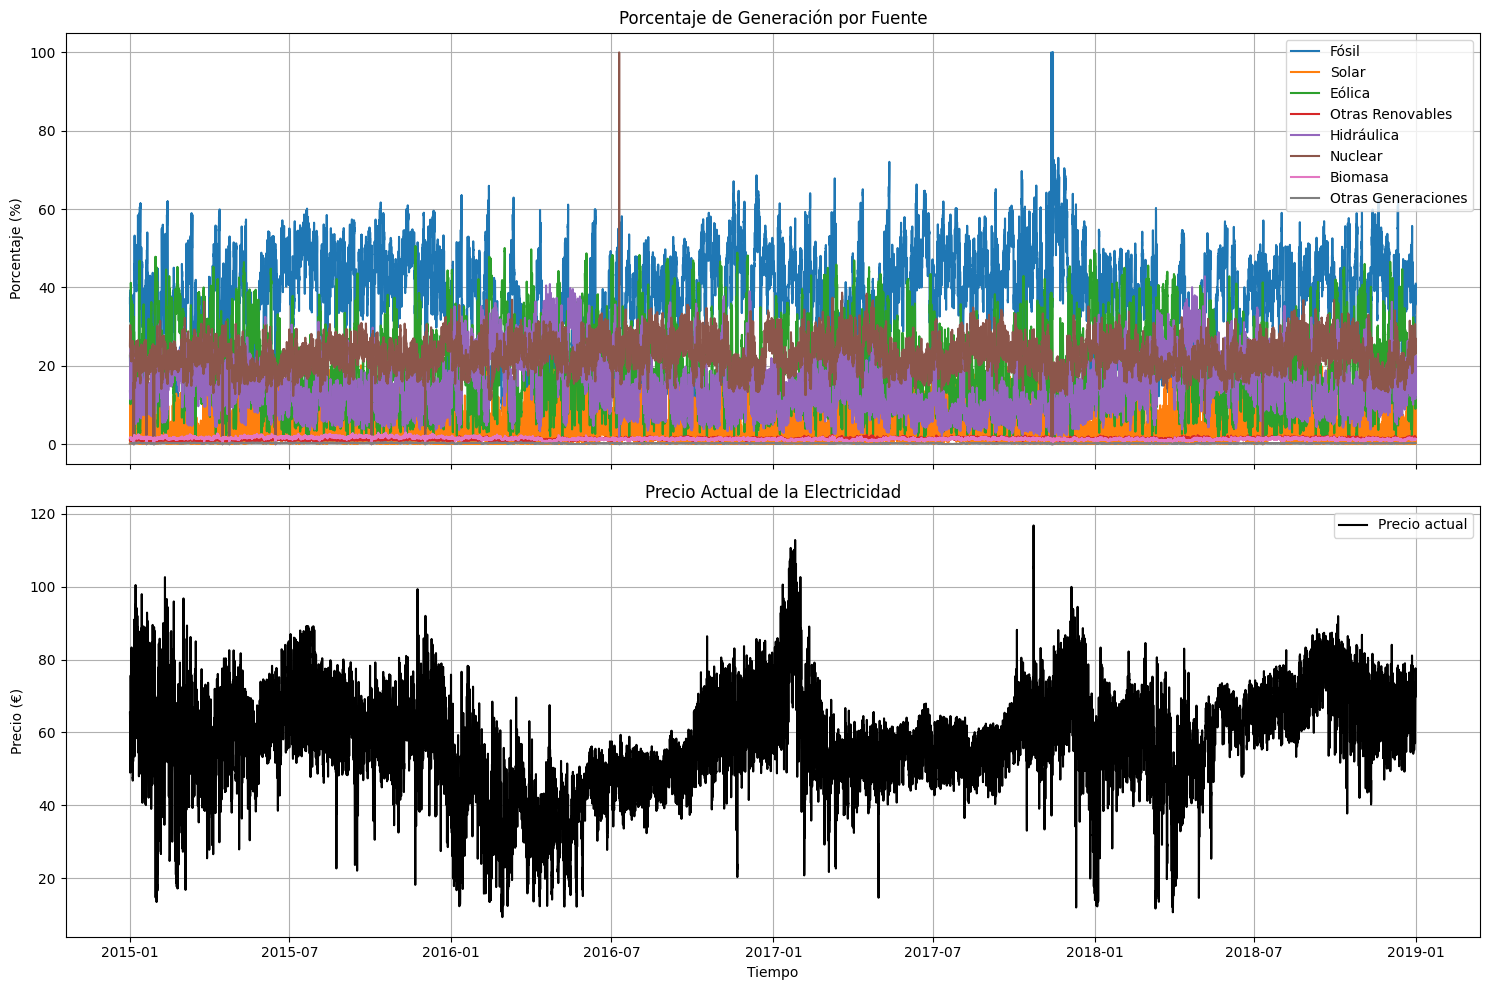

In [86]:
# Asegurar que 'time' es datetime
df_grouped['time'] = pd.to_datetime(df_grouped['time'])

# Crear figura con dos subgráficas
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Gráfico de porcentajes por fuente
ax1.plot(df_grouped['time'], df_grouped['porcentaje_fosil'], label='Fósil')
ax1.plot(df_grouped['time'], df_grouped['porcentaje_solar'], label='Solar')
ax1.plot(df_grouped['time'], df_grouped['porcentaje_eolica'], label='Eólica')
ax1.plot(df_grouped['time'], df_grouped['porcentaje_otras_renovables'], label='Otras Renovables')
ax1.plot(df_grouped['time'], df_grouped['porcentaje_hidraulica'], label='Hidráulica')
ax1.plot(df_grouped['time'], df_grouped['porcentaje_nuclear'], label='Nuclear')
ax1.plot(df_grouped['time'], df_grouped['porcentaje_biomasa'], label='Biomasa')
ax1.plot(df_grouped['time'], df_grouped['porcentaje_otras_generaciones'], label='Otras Generaciones')

ax1.set_ylabel('Porcentaje (%)')
ax1.set_title('Porcentaje de Generación por Fuente')
ax1.legend(loc='upper right')
ax1.grid(True)

# Gráfico del precio actual (con nombre corregido)
ax2.plot(df_grouped['time'], df_grouped['price actual'], color='black', label='Precio actual')
ax2.set_ylabel('Precio (€)')
ax2.set_title('Precio Actual de la Electricidad')
ax2.grid(True)
ax2.legend(loc='upper right')

# Etiqueta común eje X
ax2.set_xlabel('Tiempo')

plt.tight_layout()
plt.show()

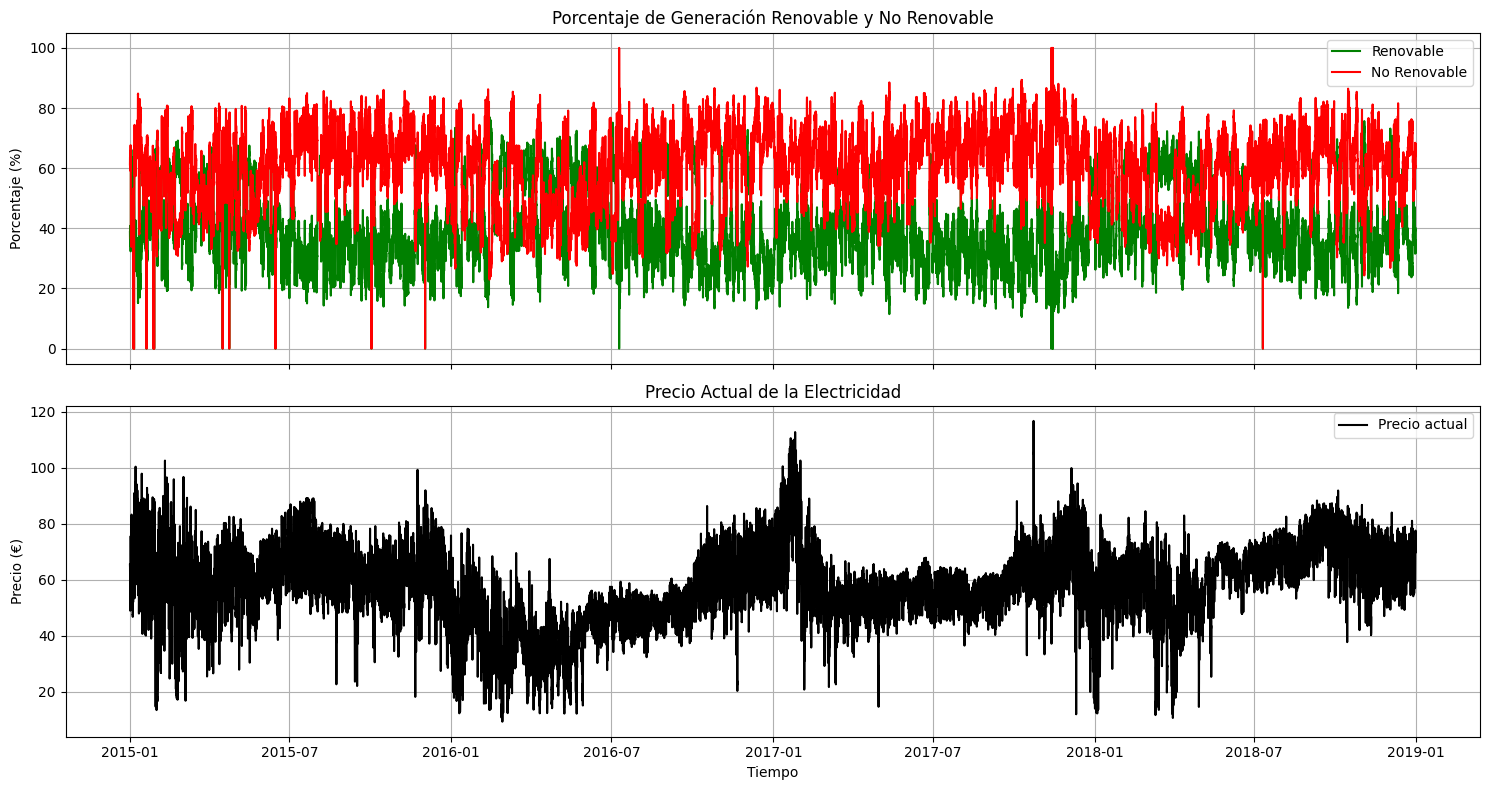

In [87]:
# Asegurar que 'time' esté en formato datetime
df_grouped['time'] = pd.to_datetime(df_grouped['time'])

# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Gráfico superior: Porcentaje renovable vs no renovable
ax1.plot(df_grouped['time'], df_grouped['porcentaje_renovable'], label='Renovable', color='green')
ax1.plot(df_grouped['time'], df_grouped['porcentaje_no_renovable'], label='No Renovable', color='red')

ax1.set_ylabel('Porcentaje (%)')
ax1.set_title('Porcentaje de Generación Renovable y No Renovable')
ax1.legend(loc='upper right')
ax1.grid(True)

# Gráfico inferior: Precio actual de la electricidad
ax2.plot(df_grouped['time'], df_grouped['price actual'], label='Precio actual', color='black')

ax2.set_xlabel('Tiempo')
ax2.set_ylabel('Precio (€)')
ax2.set_title('Precio Actual de la Electricidad')
ax2.legend(loc='upper right')
ax2.grid(True)

# Ajustar diseño
plt.tight_layout()
plt.show()

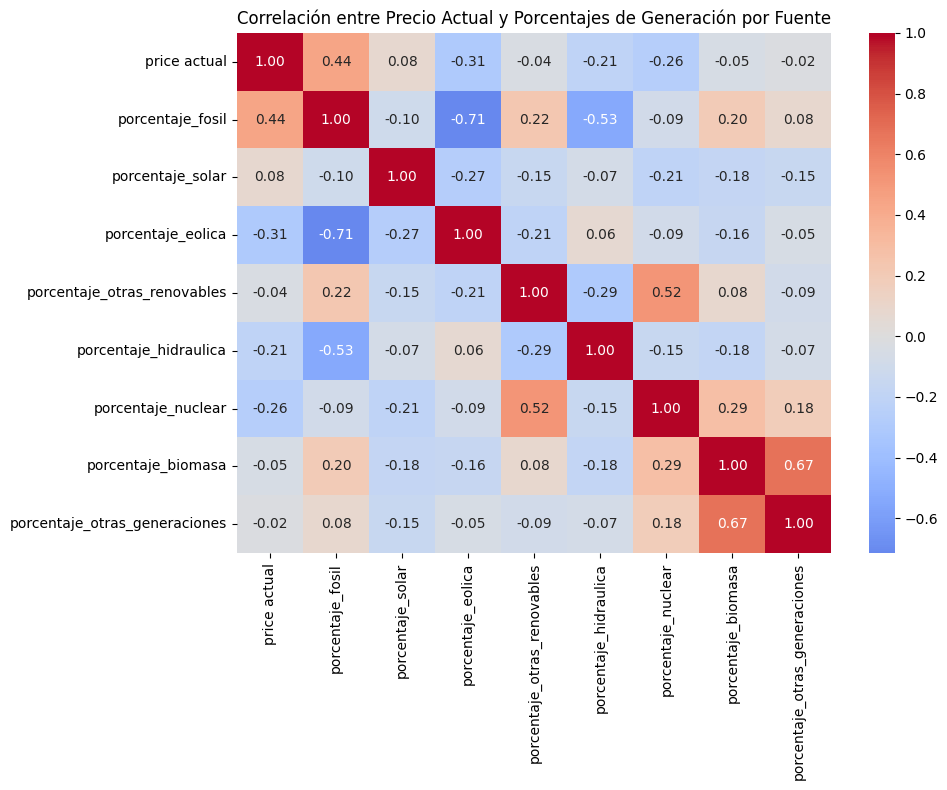

In [88]:
# Seleccionar columnas relevantes
cols = [
    'price actual',
    'porcentaje_fosil',
    'porcentaje_solar',
    'porcentaje_eolica',
    'porcentaje_otras_renovables',
    'porcentaje_hidraulica',
    'porcentaje_nuclear',
    'porcentaje_biomasa',
    'porcentaje_otras_generaciones'
]

# Calcular matriz de correlación
correlation_matrix = df_grouped[cols].corr()

# Crear heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

plt.title('Correlación entre Precio Actual y Porcentajes de Generación por Fuente')
plt.tight_layout()
plt.show()

In [94]:
# Selección de las columnas relevantes
cols = ['porcentaje_fosil', 'porcentaje_eolica', 'porcentaje_nuclear', 'porcentaje_hidraulica', 'price actual']
correlation_matrix = df_grouped[cols].corr()

print(correlation_matrix['price actual'].sort_values(ascending=False))

price actual             1.000000
porcentaje_fosil         0.439013
porcentaje_hidraulica   -0.210978
porcentaje_nuclear      -0.261716
porcentaje_eolica       -0.305628
Name: price actual, dtype: float64


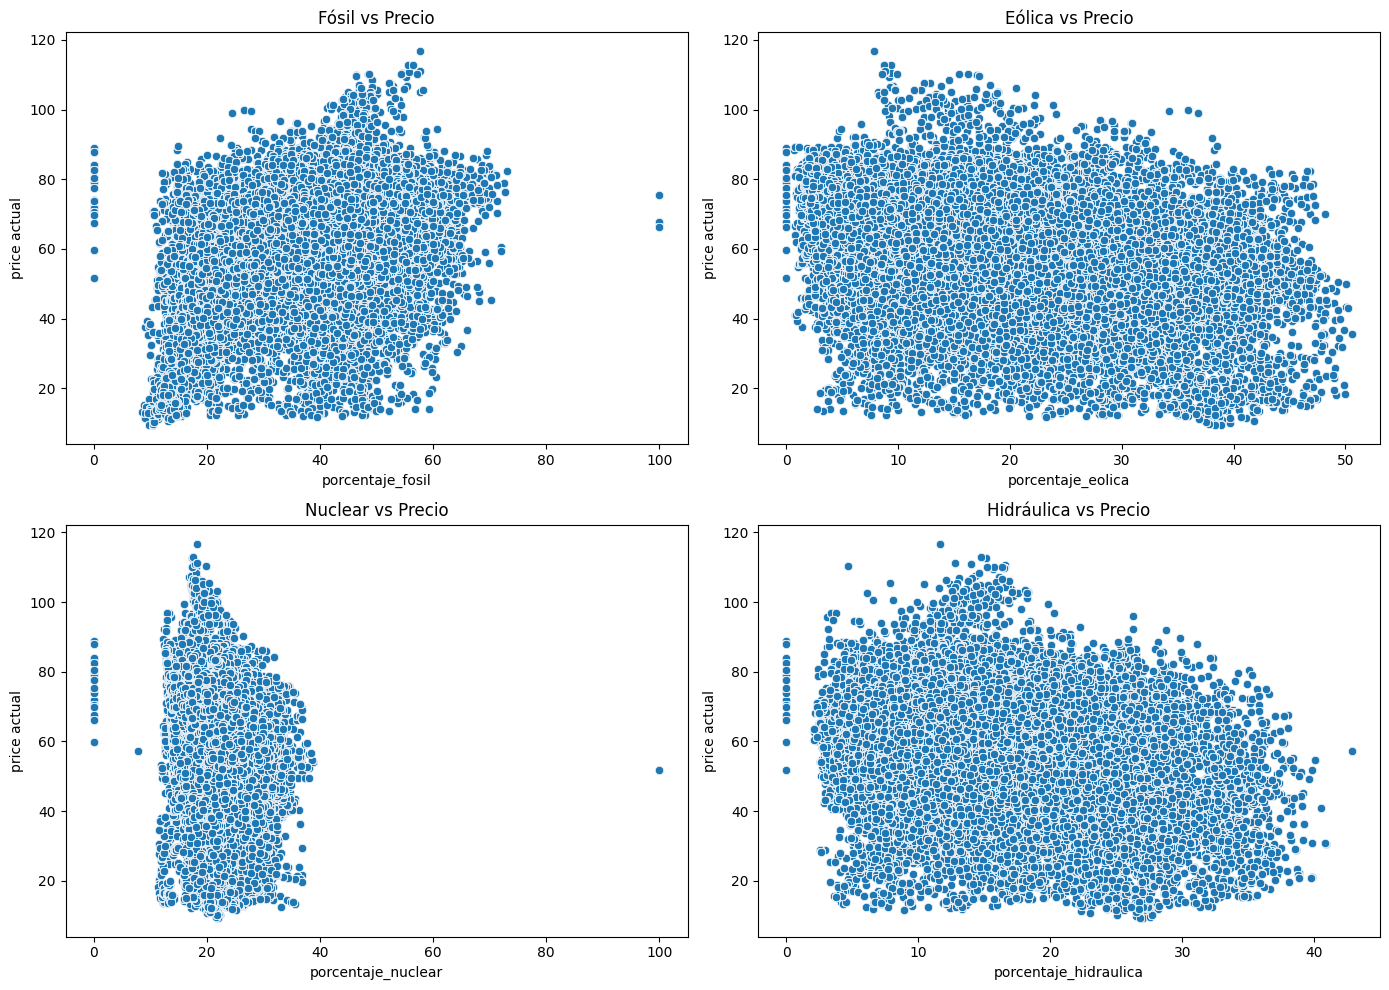

In [95]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.scatterplot(data=df_grouped, x='porcentaje_fosil', y='price actual', ax=axes[0,0])
axes[0,0].set_title('Fósil vs Precio')

sns.scatterplot(data=df_grouped, x='porcentaje_eolica', y='price actual', ax=axes[0,1])
axes[0,1].set_title('Eólica vs Precio')

sns.scatterplot(data=df_grouped, x='porcentaje_nuclear', y='price actual', ax=axes[1,0])
axes[1,0].set_title('Nuclear vs Precio')

sns.scatterplot(data=df_grouped, x='porcentaje_hidraulica', y='price actual', ax=axes[1,1])
axes[1,1].set_title('Hidráulica vs Precio')

plt.tight_layout()
plt.show()

In [96]:
X = df_grouped[['porcentaje_fosil', 'porcentaje_eolica', 'porcentaje_nuclear', 'porcentaje_hidraulica']]
y = df_grouped['price actual']
X = sm.add_constant(X)  # Añade constante al modelo

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           price actual   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                 6.427e+04
Date:                Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                        15:55:33   Log-Likelihood:            -3.0557e+06
No. Observations:              777248   AIC:                         6.111e+06
Df Residuals:                  777243   BIC:                         6.112e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    72.71

In [100]:
df_grouped.to_csv("../Data/energy_grouped.csv", index=False)